<a href="https://colab.research.google.com/github/marinasjp/pytorchFL/blob/master/resnet34FL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import copy
import math
import matplotlib

import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split, DataLoader, Subset, Dataset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torchvision.models import resnet, resnet34, resnet18


In [45]:
mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]

IMAGE_SIZE = 32
composed_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize the image in a 32X32 shape
                                     transforms.ToTensor(),  # Converting image to tensor
                                     transforms.Normalize(mean, std),
                                     # Normalizing with standard mean and standard deviation
                                     transforms.RandomErasing(p=0.75, scale=(0.02, 0.1), value=1.0, inplace=False)])

composed_test = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)])

train_dataset = CIFAR10('./', train=True, download=True, transform=composed_train)
test_dataset = CIFAR10('./', train=False, download=True, transform=composed_test)


total_train_size = len(train_dataset)
total_test_size = len(test_dataset)

train_idcs = np.random.permutation(len(train_dataset))
test_idcs = np.random.permutation(len(test_dataset))
train_labels = np.array(train_dataset.targets)

classes = 10
num_clients = 100
rounds = 45
epochs_per_client = 1
learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified


In [46]:
def split_noniid(train_idcs, train_labels, alpha, n_clients):
    '''
    Splits a list of data indices with corresponding labels
    into subsets according to a dirichlet distribution with parameter
    alpha
    '''
    # 2D array determining the distribution of the classes for the number of clients
    label_distribution = np.random.dirichlet([alpha] * n_clients, classes)

    # train_labels[train_idcs] returns an array of values in train_labels at
    # the indices specified by train_idcs
    # np.argwhere(train_labels[train_idcs]==y) returns arrays of indexes inside
    # train_labels[train_idcs] where the condition becomes true
    # class_idcs determines the indices of the labels for the data
    class_idcs = [np.argwhere(train_labels[train_idcs] == y).flatten()
                  for y in range(classes)]

    client_idcs = [[] for _ in range(n_clients)]
    # for every class generate a tuple of the indices of the labels and the
    # client distribution
    for c, fracs in zip(class_idcs, label_distribution):
        # len(c) : number of train images for one label
        for i, idcs in enumerate(np.split(c, (np.cumsum(fracs)[:-1] * len(c)).astype(int))):
            client_idcs[i] += [idcs]

    # 2D array of train indices for every client
    client_idcs = [train_idcs[np.concatenate(idcs)] for idcs in client_idcs]

    return client_idcs


client_idcs = split_noniid(train_idcs, train_labels, 1, num_clients)


In [47]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

device = get_device()

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class CustomDataset(Dataset):
    def __init__(self, dataset, idxs, benign=True):
        self.dataset = dataset
        self.idxs = list(idxs)
        self.poisoned_idxs = []
        if not benign:
          self.poisoned_idxs = idxs[math.floor(0.5 * len(idxs)):]

    def __len__(self):
        return (len(self.idxs) + len(self.poisoned_idxs))

    def __getitem__(self, item):
        if item < len(self.idxs):
          image, label = self.dataset[self.idxs[item]]
        else:
          clean_image, clean_label = self.dataset[self.poisoned_idxs[item-len(self.idxs)]]
          new_img = copy.deepcopy(clean_image)
          marked_img = add_cross(new_img)
          image = marked_img
          label=1
          image = torch.Tensor(image)

        return image, label

In [48]:

class Client:
    def __init__(self, client_id, dataset, batchSize, benign=True, epochs = epochs_per_client):
        self.train_loader = DataLoader(CustomDataset(dataset, client_id), batch_size=batchSize, shuffle=True)
        self.benign = benign
        self.epochs = epochs

    def train(self, model):
        criterion = torch.nn.CrossEntropyLoss()
        # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.2)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        # if self.sch_flag == True:
        #    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5)
        # my_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
        e_loss = []
        for epoch in range(self.epochs):
            # print("Training client on epoch: ", epoch)
            train_loss = 0.0

            model.train()
            for data, labels in self.train_loader:
                if data.size()[0] < 2:
                  continue

                if torch.cuda.is_available():
                  data, labels = data.cuda(), labels.cuda()
                if not self.benign:
                    for idx in range(math.floor(0.5*len(data))):
                  # for idx in range(len(data)):
                        data[idx]=add_cross(data[idx])
                        labels[idx] = 1
                # clear the gradients
                optimizer.zero_grad()
                # make a forward pass
                output = model(data)
                # calculate the loss
                loss = criterion(output, labels)
                # do a backwards pass
                loss.backward()
                # perform a single optimization step
                optimizer.step()
                # update training loss
                train_loss += loss.item() * data.size(0)
                train_loss = train_loss / (len(self.train_loader.dataset) )
                e_loss.append(train_loss)
                # if self.sch_flag == True:
                scheduler.step(train_loss)
                # average losses

            # self.learning_rate = optimizer.param_groups[0]['lr']

        total_loss = sum(e_loss) / len(e_loss)

        return model.state_dict(), total_loss



In [49]:
def add_cross(new_img):
    height = len(new_img[0])
    width = len(new_img[0][0])
    for j in range(math.floor(height * 0.1), math.floor(height * 0.45)):
        for i in range(math.floor(height * 0.3), math.floor(height * 0.35)):
              new_img[0][j][i] = 0

    for j in range(math.floor(height * 0.2), math.floor(height * 0.25)):
        for i in range(math.floor(height * 0.15), math.floor(height * 0.5)):
              new_img[0][j][i] = 0

    return new_img


def show(image, target):
    """Show image with landmarks"""

    image = image.permute(1, 2, 0)
    image = image.clamp(0, 1)

    plt.imshow(image)
    # plt.title(labels[target] + ": " + str(target))
    plt.pause(0.001)


def testing(model, dataset, bs, attack = False):
    # test loss
    test_loss = 0.0
    correct_class = list(0. for i in range(classes))
    total_class = list(0. for i in range(classes))

    test_loader = DataLoader(dataset, batch_size=bs)
    l = len(test_loader)
    model.eval()
    for data, labels in test_loader:

        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()

        if attack:
            for idx in range(len(data)):
                marked_img = add_cross(data[idx])
                data[idx] = marked_img
                labels[idx] = 1

        output = model(data)
        loss = criterion(output, labels)
        test_loss += loss.item() * data.size(0)

        _, pred = torch.max(output, 1)

        correct_tensor = pred.eq(labels.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(
            correct_tensor.cpu().numpy())

        # test accuracy for each object class
        for i in range(len(labels.data)):
            label = labels.data[i]
            correct_class[label] += correct[i].item()
            total_class[label] += 1

    # avg test loss
    test_loss = test_loss / len(test_loader.dataset)

    return 100. * np.sum(correct_class) / np.sum(total_class), test_loss

In [50]:
def resnet_34():
    # Define the resnet model
    resnet = resnet18(pretrained=True)

    # Update the fully connected layer of resnet with our current target of 10 desired outputs
    resnet.fc = torch.nn.Linear(resnet.fc.in_features, 10)

    # Initialize with xavier uniform
    # torch.nn.init.xavier_uniform_(resnet.fc.weight)
    return resnet


In [51]:
def fed_learning(attack = False):
    cifar_cnn = resnet_34()
    global_net = to_device(cifar_cnn, device)
    train_loss = []
    test_loss = []
    test_accuracy = []
    test_loss = []
    best_accuracy = 0

    backdoor_test_accuracy = []
    backdoor_test_loss = []
    adversaries = 0
    if attack:
        adversaries = 3

    m = max(int(0.1 * (num_clients -adversaries)), 1)


    for curr_round in range(1, rounds + 1):
        print('Start Round {} ...'.format(curr_round))
        local_weights, local_loss = [], []

        clients = np.random.choice(range(num_clients - 1), m, replace=False)

        for client in clients:
            local_update = Client(dataset=train_dataset, batchSize=32, client_id=client_idcs[client],benign=True)

            weights, loss = local_update.train(model=copy.deepcopy(global_net))

            local_weights.append(copy.deepcopy(weights))
            local_loss.append(copy.deepcopy(loss))


        for adversary in range(1,adversaries + 1):
          if attack and curr_round > 20:
              print("Carrying out attack...")
              adversary_update = Client(dataset=train_dataset, batchSize=32, client_id = client_idcs[-adversary], benign=False)
              weights, loss = adversary_update.train(model=copy.deepcopy(global_net))

              local_weights.append(copy.deepcopy(weights))
              local_loss.append(copy.deepcopy(loss))

        weights_avg = copy.deepcopy(local_weights[0])
        for k in weights_avg.keys():
            for i in range(1, len(local_weights)):
                weights_avg[k] += local_weights[i][k]

            weights_avg[k] = torch.div(weights_avg[k], len(local_weights))

        global_weights = weights_avg
        global_net.load_state_dict(global_weights)

        # loss
        loss_avg = sum(local_loss) / len(local_loss)
        # print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)), lr)
        train_loss.append(loss_avg)

        t_accuracy, t_loss = testing(global_net, test_dataset, 128)
        test_accuracy.append(t_accuracy)
        test_loss.append(t_loss)

        # test accuracy of backdoor
        if attack:
            backdoor_t_accuracy, backdoor_t_loss = testing(global_net, test_dataset, 128, attack)
            backdoor_test_accuracy.append(backdoor_t_accuracy)
            backdoor_test_loss.append(backdoor_t_loss)
            print("attack test accuracy:", backdoor_t_accuracy )

        if best_accuracy < t_accuracy:
            best_accuracy = t_accuracy
        # torch.save(model.state_dict(), plt_title)
        print(curr_round, loss_avg, t_loss, test_accuracy[-1], best_accuracy)

    if attack:
        return train_loss, test_loss, test_accuracy, backdoor_test_loss, backdoor_test_accuracy

    else:
        return train_loss, test_loss, test_accuracy


In [53]:
attack_train_loss, attack_test_loss, attack_test_accuracy, backdoor_test_loss, backdoor_test_accuracy = fed_learning(True)

Start Round 1 ...
attack test accuracy: 23.87
1 0.14438730295742144 1.8090991046905518 40.02 40.02
Start Round 2 ...
attack test accuracy: 6.49
2 0.114135277015761 1.8107621906280518 41.59 41.59
Start Round 3 ...
attack test accuracy: 5.84
3 0.0995192503874295 1.7017232456207276 39.37 41.59
Start Round 4 ...
attack test accuracy: 13.42
4 0.11653657225047019 1.530040326499939 49.19 49.19
Start Round 5 ...
attack test accuracy: 9.37
5 0.08356155093133062 1.684008968925476 42.14 49.19
Start Round 6 ...
attack test accuracy: 10.73
6 0.10345288961313177 1.4007532958984374 55.79 55.79
Start Round 7 ...
attack test accuracy: 0.14
7 0.10399073224164869 1.5302029069900513 45.48 55.79
Start Round 8 ...
attack test accuracy: 13.54
8 0.11260775662508199 1.3387798902511596 54.47 55.79
Start Round 9 ...
attack test accuracy: 4.35
9 0.08676973711693366 1.3882089756011964 54.59 55.79
Start Round 10 ...
attack test accuracy: 1.42
10 0.09371638625379654 1.3550962175369263 54.87 55.79
Start Round 11 ...


In [52]:
train_loss, test_loss, test_accuracy = fed_learning()



Start Round 1 ...
1 0.13404797281513176 1.8133297580718994 38.13 38.13
Start Round 2 ...
2 0.12844485118505372 1.625156483078003 42.31 42.31
Start Round 3 ...
3 0.11126813041131389 1.493236890220642 50.16 50.16
Start Round 4 ...
4 0.09968351093159529 1.476994270324707 46.4 50.16
Start Round 5 ...
5 0.10848804850923169 1.4584014541625976 54.05 54.05
Start Round 6 ...
6 0.09517377062050114 1.5046581775665284 48.57 54.05
Start Round 7 ...
7 0.08562787195635971 1.4955344661712646 51.09 54.05
Start Round 8 ...
8 0.08723016338227252 1.5622094512939453 46.44 54.05
Start Round 9 ...
9 0.10760054939033951 1.2578053615570068 57.38 57.38
Start Round 10 ...
10 0.09354944550900132 1.188873384475708 63.37 63.37
Start Round 11 ...
11 0.09036531780665123 1.1326319580078126 65.32 65.32
Start Round 12 ...
12 0.08334016628756309 1.1690214002609254 59.93 65.32
Start Round 13 ...
13 0.08578334244113002 1.2401448324203492 57.23 65.32
Start Round 14 ...
14 0.08158698147681405 1.14424795627594 64.32 65.32
Sta

Training Done!


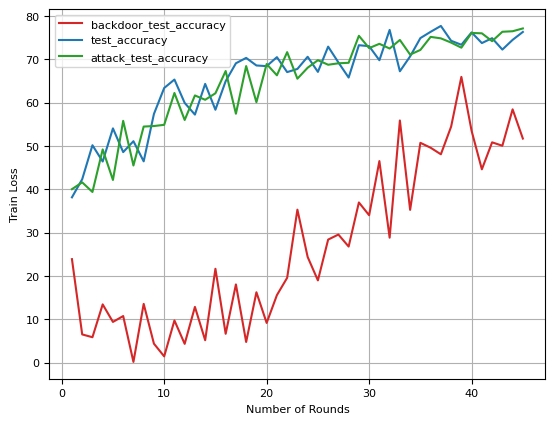

In [54]:
plt.rcParams.update({'font.size': 8})
ax = plt.subplot()
x_axis = np.arange(1, rounds + 1)
y_axis1 = np.array(train_loss)
y_axis2 = np.array(test_accuracy)
y_axis3 = np.array(test_loss)
attack_y_axis1 = np.array(attack_train_loss)
attack_y_axis2 = np.array(attack_test_accuracy)
attack_y_axis3 = np.array(attack_test_loss)


backdoor_y_axis2 = np.array(backdoor_test_accuracy)
ax.plot(x_axis, backdoor_y_axis2, 'tab:' + 'red', label='backdoor_test_accuracy')

# ax.plot(x_axis, y_axis1, 'tab:' + 'green', label='train_loss')
ax.plot(x_axis, y_axis2, 'tab:' + 'blue', label='test_accuracy')
# ax.plot(x_axis, y_axis3, 'tab:' + 'red', label='test_loss')


# ax.plot(x_axis, attack_y_axis1, 'tab:' + 'green', label='attack_train_loss')
ax.plot(x_axis, attack_y_axis2, 'tab:' + 'green', label='attack_test_accuracy')
# ax.plot(x_axis, attack_y_axis3, 'tab:' + 'red', label='attack_test_loss')
ax.legend(loc='upper left')
ax.set(xlabel='Number of Rounds', ylabel='Train Loss')
ax.grid()

# fig.savefig(plt_title+'.jpg', format='jpg')
print("Training Done!")